# Full Forex EURUSD environment RL training and hyperparameter tuning

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(""), os.pardir)))
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(""), os.pardir, 'rl-baselines3-zoo')))

In [2]:
import gym
import joblib
import rl_trading
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, timedelta
from optuna.visualization import plot_optimization_history, plot_param_importances
from gym.envs.registration import register, make
from sb3_contrib import RecurrentPPO
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from rl_zoo3.train import train
from rl_zoo3.plots.all_plots import all_plots
from rl_zoo3.plots.plot_from_file import plot_from_file
from rl_zoo3.plots.plot_train import plot_train
from rl_zoo3.utils import get_model_path
from rl_trading.data import (
    FOREX_PAIRS,
    ForexDataSource,
    ForexFeEngStrategy,
    load_processed_forex_data,
    engineer_forex_features
)
from rl_trading.environments import (
    Actions,
    ForexEnvBasic,
    ForexMarketOrderStrategyAllIn,
    ForexRewardStrategyLogPortfolioReturn,
    ForexTradingCostsStrategySpread,
    TrnOrEvalForexWrapper,
    RandomEpisodeForexWrapper
)
from rl_trading.utils import *
from tensorboard import notebook
from config import (
    DATA_PATH, 
    LOGS_PATH,
    HYPERPARAMS_PATH
)

In [3]:
%load_ext tensorboard

In [4]:
RANDOM_SEED = 604

In [5]:
TARGET = 'EURUSD'

In [6]:
EVAL_END_DATE = datetime(2022,9,30,18,45,0)
EVAL_START_DATE = EVAL_END_DATE - timedelta(hours=25000)
VAL_START_DATE = EVAL_START_DATE - timedelta(hours=25000)
TRN_START_DATE = datetime(2003,1,2,1,0,0)

In [7]:
forex_data = load_processed_forex_data(DATA_PATH, ForexDataSource.FOREXTESTER, pairs=FOREX_PAIRS, version='Agg')

In [8]:
target_prices = forex_data[TARGET]

target_prices_trn = target_prices[
    (target_prices['<DT>'] >= TRN_START_DATE) & (target_prices['<DT>'] < VAL_START_DATE)
].reset_index(drop=True)

target_prices_val = target_prices[
    (target_prices['<DT>'] >= VAL_START_DATE) & (target_prices['<DT>'] < EVAL_START_DATE)
].reset_index(drop=True)

target_prices_eval = target_prices[
    (target_prices['<DT>'] >= EVAL_START_DATE) & (target_prices['<DT>'] < EVAL_END_DATE)
].reset_index(drop=True)

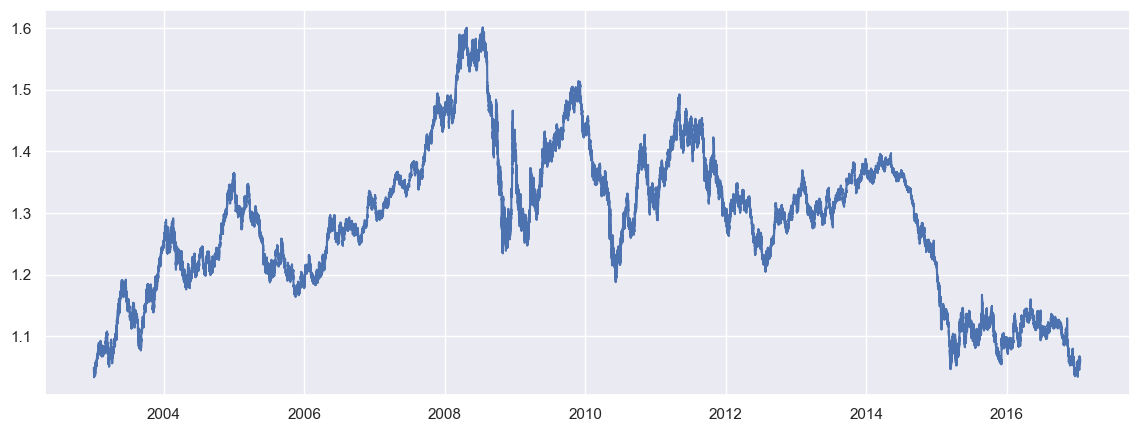

In [9]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_trn['<DT>'], target_prices_trn['<OPEN>'])

In [10]:
len(target_prices_trn)

492327

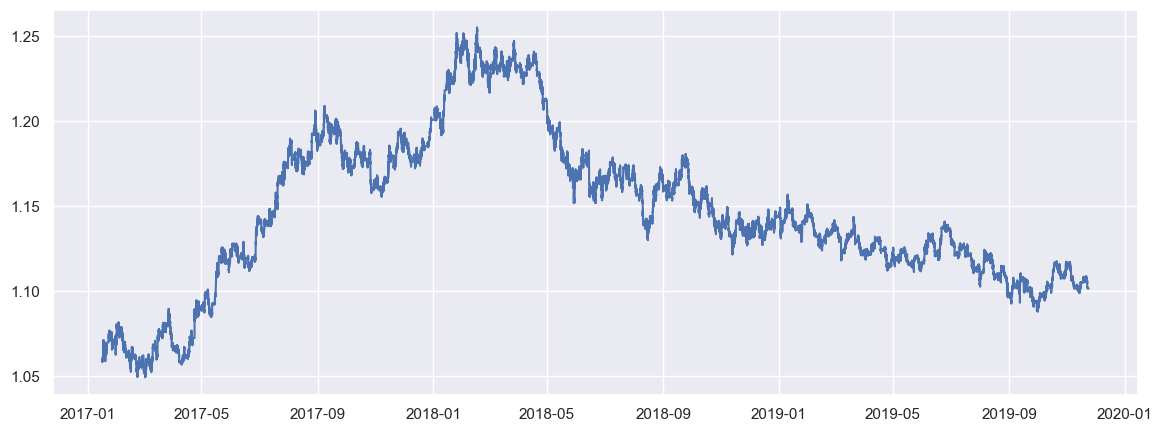

In [11]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_val['<DT>'], target_prices_val['<OPEN>'])

In [12]:
len(target_prices_val)

100000

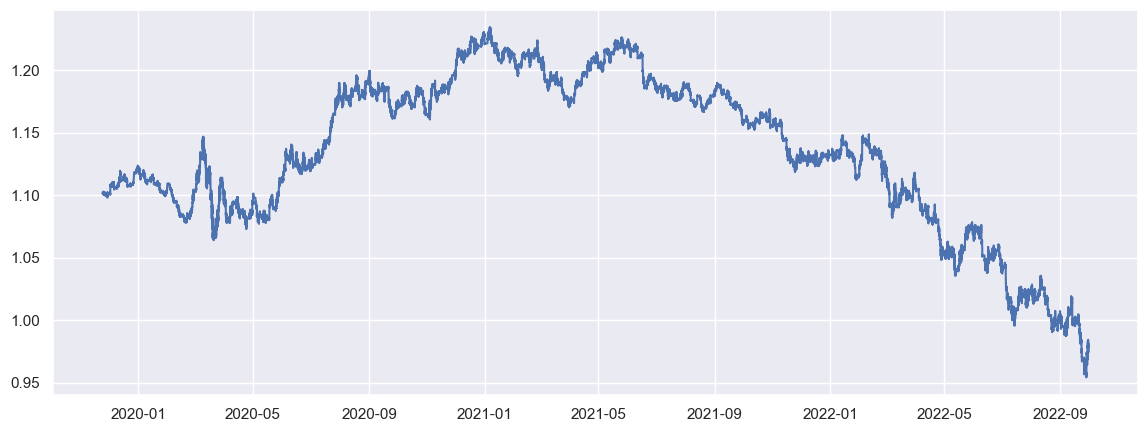

In [13]:
plt.figure(figsize=(14,5))
plt.plot(target_prices_eval['<DT>'], target_prices_eval['<OPEN>'])

In [14]:
features = engineer_forex_features(forex_data, ForexFeEngStrategy.STRATEGY1, {'recent_returns' : 8})

In [15]:
features_trn = features[
    (features['<DT>'] >= TRN_START_DATE) & (features['<DT>'] < VAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

features_val = features[
    (features['<DT>'] >= VAL_START_DATE) & (features['<DT>'] < EVAL_START_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

features_eval = features[
    (features['<DT>'] >= EVAL_START_DATE) & (features['<DT>'] < EVAL_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

In [16]:
def create_eurusd_env(
    eval,
    env_kwargs,
    trn_wrappers={},
    eval_wrappers={}
):
    env = ForexEnvBasic(
        target_prices_trn,
        features_trn,
        **deepcopy(env_kwargs)
    )
    return TrnOrEvalForexWrapper(
        env,
        target_prices_val,
        features_val,
        eval,
        trn_wrappers,
        eval_wrappers
    )

In [17]:
BASE_ENV_KWARGS = dict(
    portfolio_value=1000,
    allowed_actions={Actions.SELL, Actions.BUY},
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001),
    include_in_obs = ['position']
)

In [ ]:
#%tensorboard --logdir {LOGS_PATH}/training/TensorBoard

## Full Forex EURUSD environment, 2 actions, running normalization

In [18]:
def create_full_eurusd_env_v1(eval):
    return create_eurusd_env(
        eval,
        BASE_ENV_KWARGS
    )

In [19]:
register(
    'ForexFullEURUSD-v1',
    entry_point=create_full_eurusd_env_v1
)

### DQN

In [20]:
sys.argv = [
    'python', 
    '--algo', 'dqn',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/dqn.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 32),
             ('buffer_size', 1000000),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('exploration_final_eps', 0.05),
             ('exploration_fraction', 0.1),
             ('gamma', 0.99),
             ('gradient_steps', 1),
             ('learning_rate', 0.0001),
             ('learning_starts', 50000),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict( net_arch=[64, 64] )'),
             ('target_update_interval', 10000),
             ('train_freq', 4)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v1_2


  2%|▌                          | 100289/5000000 [00:39<16:44:50, 81.27it/s]

Eval num_timesteps=100000, episode_reward=-4.56 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200361/5000000 [01:28<14:52:27, 89.63it/s]

Eval num_timesteps=200000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|█▌                         | 300393/5000000 [02:18<15:09:50, 86.09it/s]

Eval num_timesteps=300000, episode_reward=-1.12 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  8%|██▏                        | 400269/5000000 [03:08<14:40:18, 87.09it/s]

Eval num_timesteps=400000, episode_reward=-0.39 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 10%|██▋                        | 500333/5000000 [04:00<15:27:04, 80.89it/s]

Eval num_timesteps=500000, episode_reward=-1.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600187/5000000 [04:54<17:01:44, 71.77it/s]

Eval num_timesteps=600000, episode_reward=-1.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700235/5000000 [05:49<20:49:11, 57.37it/s]

Eval num_timesteps=700000, episode_reward=-0.74 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800185/5000000 [06:43<18:47:54, 62.06it/s]

Eval num_timesteps=800000, episode_reward=0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 18%|████▊                      | 900188/5000000 [07:42<16:28:17, 69.14it/s]

Eval num_timesteps=900000, episode_reward=-0.49 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000269/5000000 [08:37<14:45:52, 75.25it/s]

Eval num_timesteps=1000000, episode_reward=-1.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|█████▋                    | 1100121/5000000 [09:35<25:07:59, 43.10it/s]

Eval num_timesteps=1100000, episode_reward=-2.14 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|██████▏                   | 1200177/5000000 [10:45<17:09:28, 61.52it/s]

Eval num_timesteps=1200000, episode_reward=-1.42 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|███████                    | 1299984/5000000 [11:44<31:40, 1946.99it/s]

Eval num_timesteps=1300000, episode_reward=-2.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████▎                  | 1400145/5000000 [13:04<20:56:26, 47.75it/s]

Eval num_timesteps=1400000, episode_reward=-1.82 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|███████▊                  | 1500021/5000000 [14:32<54:05:17, 17.97it/s]

Eval num_timesteps=1500000, episode_reward=-1.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▎                 | 1600065/5000000 [16:26<22:23:55, 42.16it/s]

Eval num_timesteps=1600000, episode_reward=-1.85 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|████████▊                 | 1700315/5000000 [17:26<12:11:25, 75.19it/s]

Eval num_timesteps=1700000, episode_reward=-1.26 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800224/5000000 [18:22<11:45:38, 75.58it/s]

Eval num_timesteps=1800000, episode_reward=-0.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|█████████▉                | 1900045/5000000 [19:33<23:26:52, 36.72it/s]

Eval num_timesteps=1900000, episode_reward=-1.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|██████████▍               | 2000186/5000000 [20:39<17:11:19, 48.48it/s]

Eval num_timesteps=2000000, episode_reward=-0.62 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|██████████▉               | 2100253/5000000 [21:38<10:52:43, 74.04it/s]

Eval num_timesteps=2100000, episode_reward=-0.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|███████████▍              | 2200173/5000000 [22:35<11:55:43, 65.20it/s]

Eval num_timesteps=2200000, episode_reward=-0.69 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|███████████▉              | 2300191/5000000 [23:32<11:22:01, 65.97it/s]

Eval num_timesteps=2300000, episode_reward=-0.80 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400193/5000000 [24:44<11:59:59, 60.18it/s]

Eval num_timesteps=2400000, episode_reward=-0.72 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500105/5000000 [25:42<14:14:33, 48.76it/s]

Eval num_timesteps=2500000, episode_reward=-0.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|█████████████▌            | 2600078/5000000 [26:42<17:21:50, 38.39it/s]

Eval num_timesteps=2600000, episode_reward=-0.30 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|██████████████▌            | 2700388/5000000 [27:38<8:31:21, 74.95it/s]

Eval num_timesteps=2700000, episode_reward=0.01 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|███████████████            | 2800225/5000000 [28:47<8:19:06, 73.46it/s]

Eval num_timesteps=2800000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████▋           | 2899835/5000000 [29:33<14:19, 2442.97it/s]

Eval num_timesteps=2900000, episode_reward=-0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|████████████████▏          | 3000189/5000000 [31:05<8:15:53, 67.21it/s]

Eval num_timesteps=3000000, episode_reward=-0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████▋          | 3100345/5000000 [32:00<7:10:27, 73.55it/s]

Eval num_timesteps=3100000, episode_reward=-0.28 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|█████████████████▎         | 3200233/5000000 [32:54<6:12:13, 80.59it/s]

Eval num_timesteps=3200000, episode_reward=-0.75 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|█████████████████▊         | 3300337/5000000 [33:45<5:33:27, 84.95it/s]

Eval num_timesteps=3300000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|██████████████████▎        | 3400214/5000000 [34:37<5:12:50, 85.23it/s]

Eval num_timesteps=3400000, episode_reward=-0.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|██████████████████▉        | 3500257/5000000 [35:29<4:51:48, 85.66it/s]

Eval num_timesteps=3500000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600305/5000000 [36:21<4:43:02, 82.42it/s]

Eval num_timesteps=3600000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700216/5000000 [37:12<4:53:08, 73.90it/s]

Eval num_timesteps=3700000, episode_reward=-0.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|████████████████████▌      | 3800145/5000000 [38:06<6:33:57, 50.76it/s]

Eval num_timesteps=3800000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900213/5000000 [39:07<4:42:25, 64.90it/s]

Eval num_timesteps=3900000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000121/5000000 [40:32<4:51:13, 57.22it/s]

Eval num_timesteps=4000000, episode_reward=-0.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100204/5000000 [41:29<4:14:17, 58.97it/s]

Eval num_timesteps=4100000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200199/5000000 [42:24<3:39:13, 60.80it/s]

Eval num_timesteps=4200000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300253/5000000 [43:19<2:42:16, 71.87it/s]

Eval num_timesteps=4300000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400130/5000000 [44:18<2:49:40, 58.92it/s]

Eval num_timesteps=4400000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500333/5000000 [45:25<2:01:13, 68.70it/s]

Eval num_timesteps=4500000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600142/5000000 [46:24<1:36:06, 69.34it/s]

Eval num_timesteps=4600000, episode_reward=-0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700173/5000000 [47:20<1:05:54, 75.82it/s]

Eval num_timesteps=4700000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|█████████████████████████▉ | 4800149/5000000 [48:15<1:00:09, 55.36it/s]

Eval num_timesteps=4800000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900186/5000000 [49:13<28:36, 58.15it/s]

Eval num_timesteps=4900000, episode_reward=0.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


100%|███████████████████████████| 5000000/5000000 [50:11<00:00, 1660.18it/s]

Eval num_timesteps=5000000, episode_reward=0.02 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/dqn/ForexFullEURUSD-v1_2


#### Final model

In [21]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v1')

Loading latest experiment, id=2


In [23]:
model = DQN.load(model_path)

##### Train set results

In [22]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [24]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:40<00:00, 4883.70it/s]


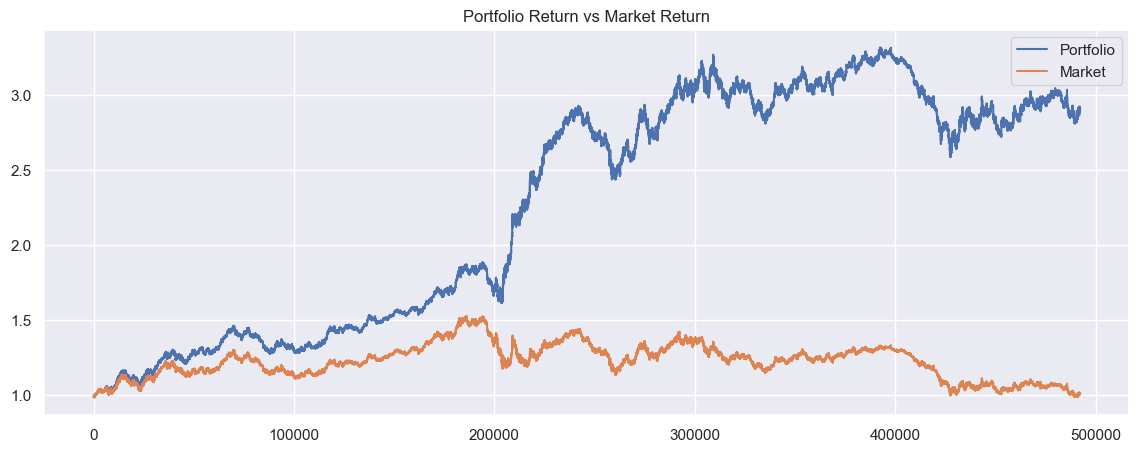

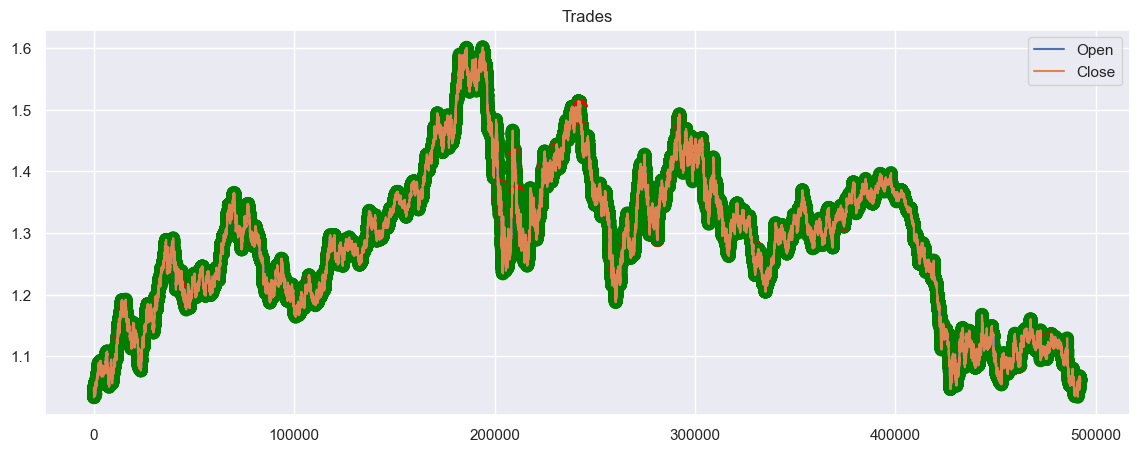

In [25]:
eurusd_env_trn.render()

In [29]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

1250

##### Validation set results

In [30]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [31]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:20<00:00, 4888.34it/s]


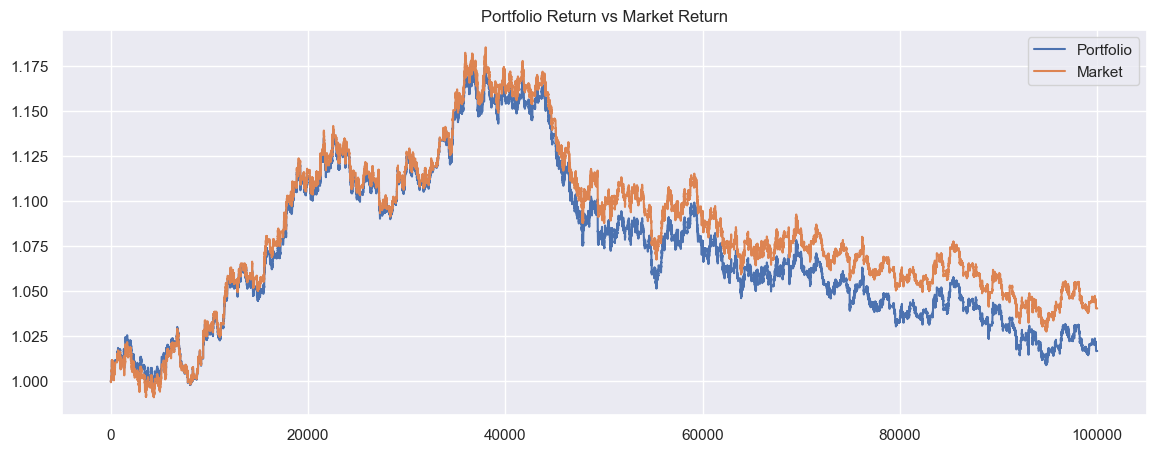

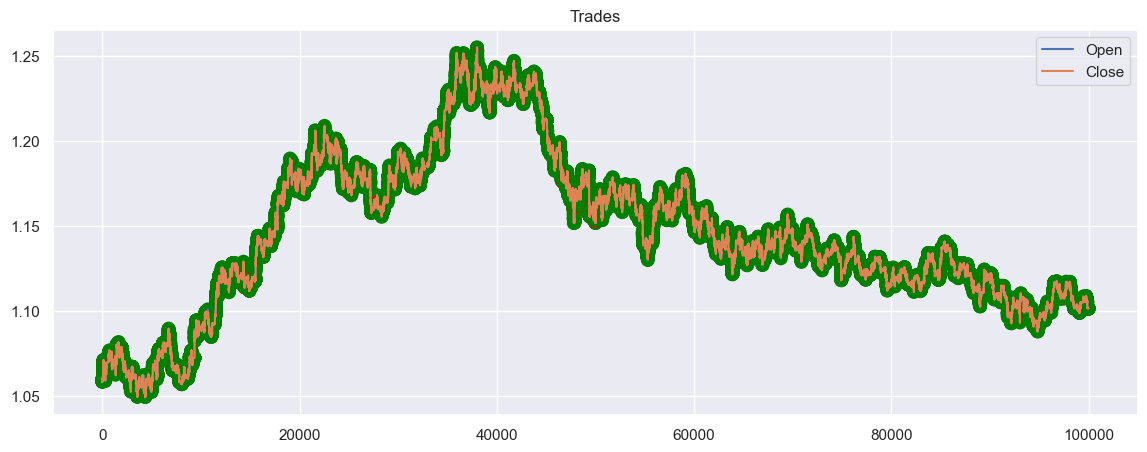

In [32]:
eurusd_env_val.render()

In [33]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

149

##### Evaluation set results

In [37]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [38]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:18<00:00, 5396.68it/s]


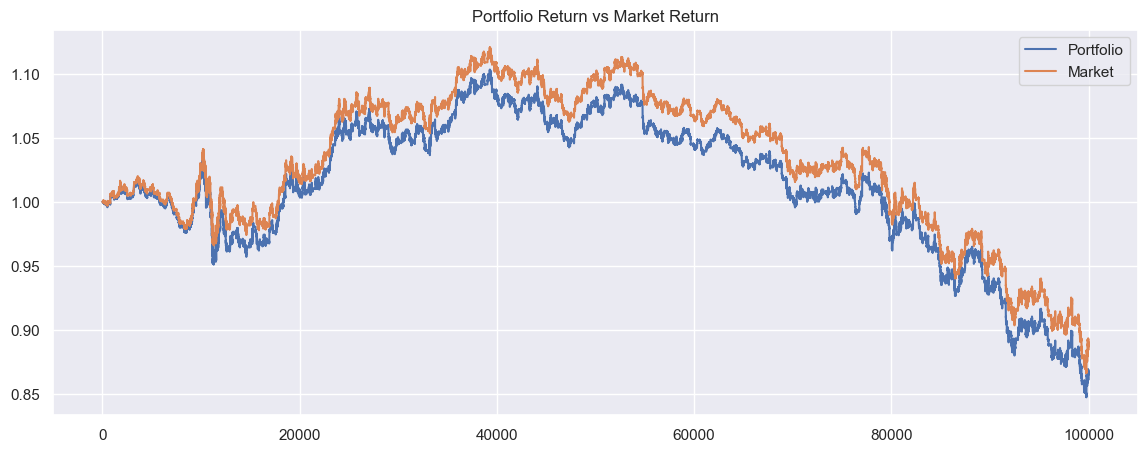

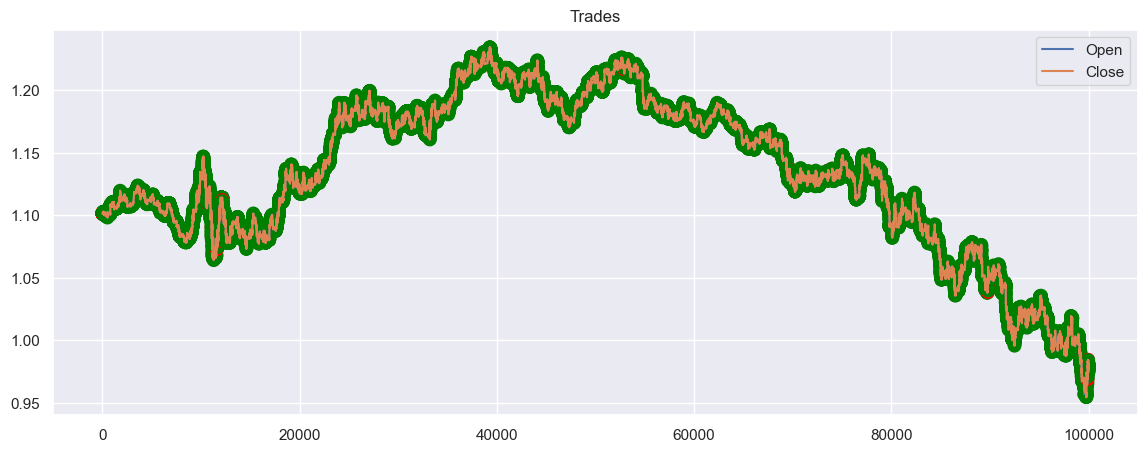

In [39]:
eurusd_env_eval.render()

In [40]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

148

#### Best model

In [41]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'dqn', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=2


In [42]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [43]:
best_model_vecnormalize

'vecnormalize_800000_steps.pkl'

In [45]:
best_model = DQN.load(best_model_path)

##### Train set results

In [44]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [46]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:35<00:00, 5146.43it/s]


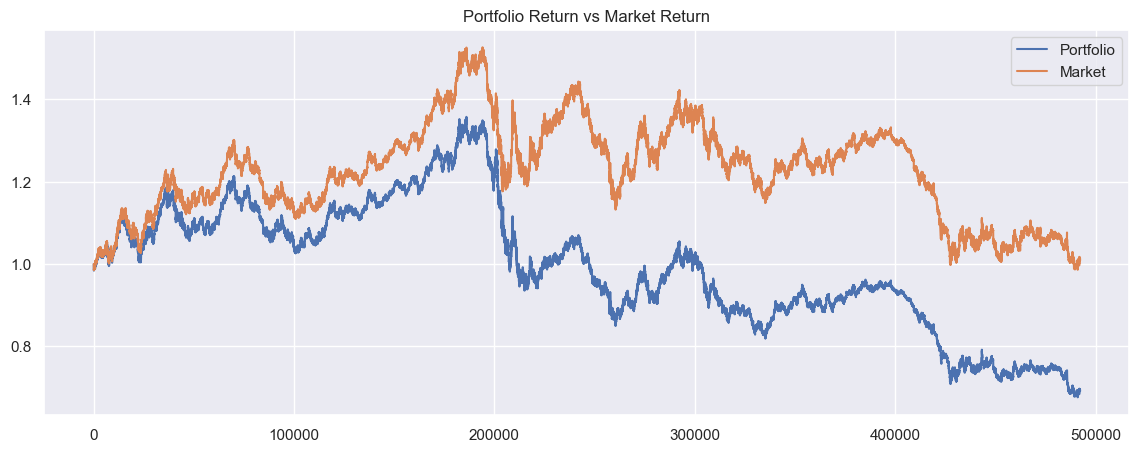

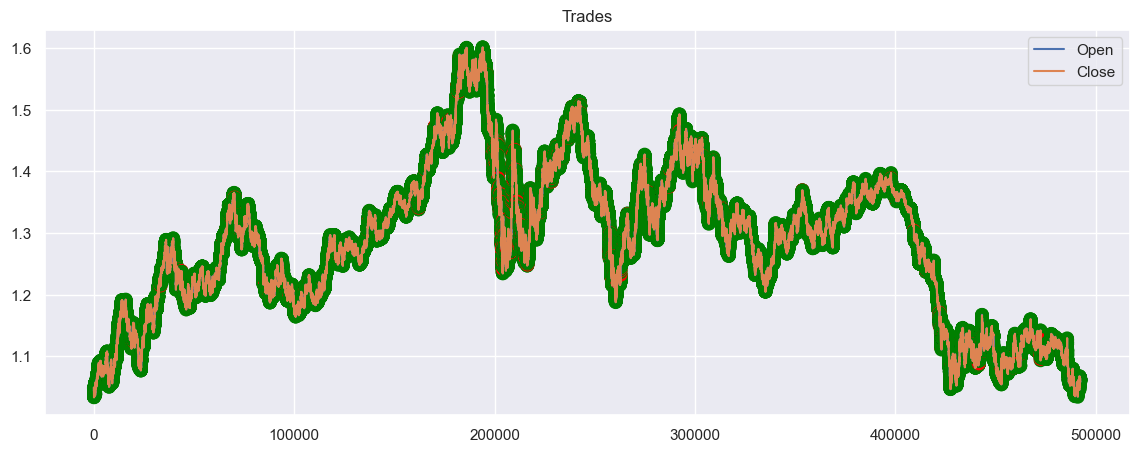

In [47]:
eurusd_env_trn.render()

In [48]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

2382

##### Validation set results

In [49]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [50]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:19<00:00, 5169.42it/s]


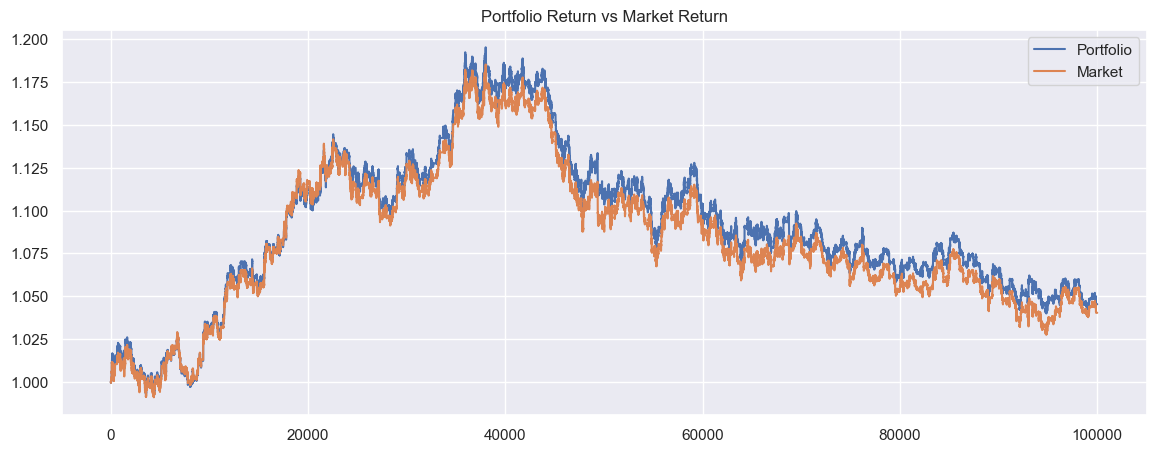

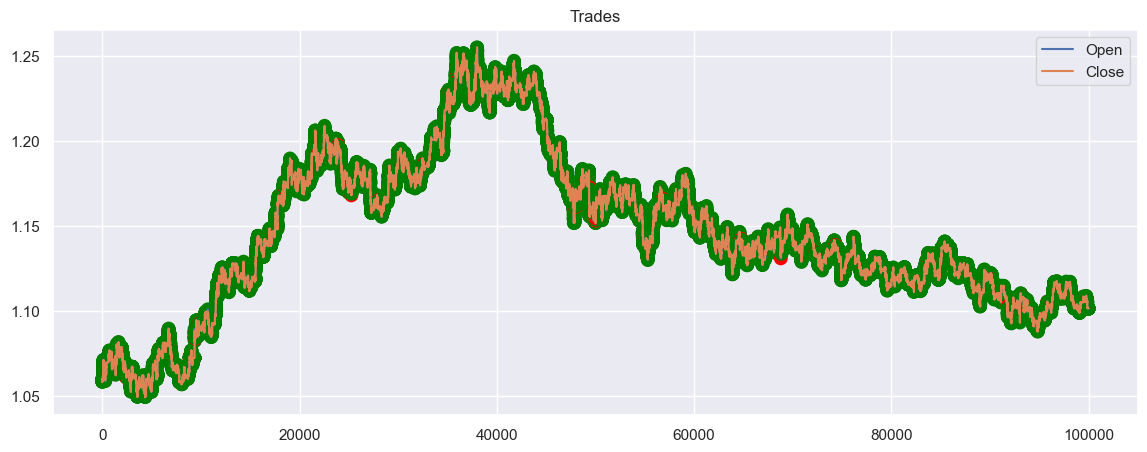

In [51]:
eurusd_env_val.render()

In [52]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

212

##### Evaluation set results

In [53]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [54]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:19<00:00, 5167.21it/s]


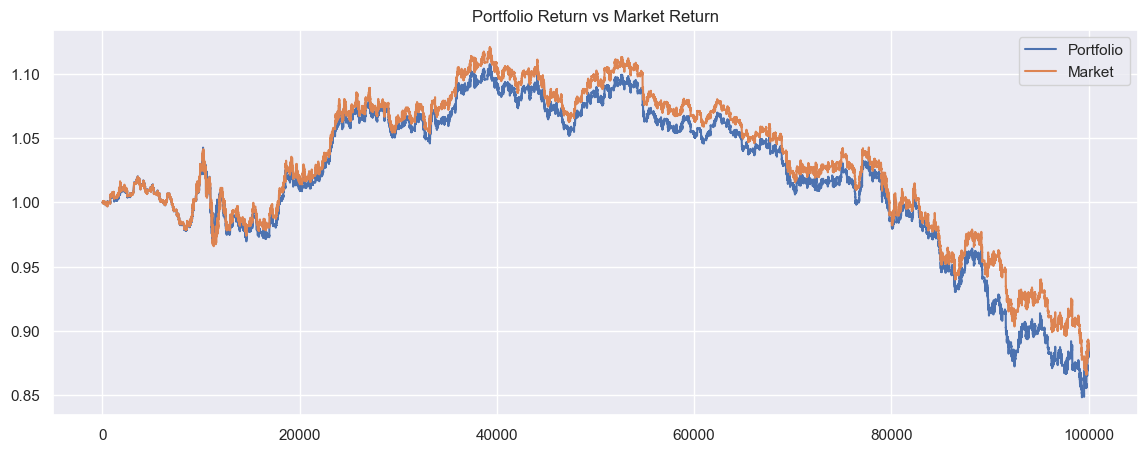

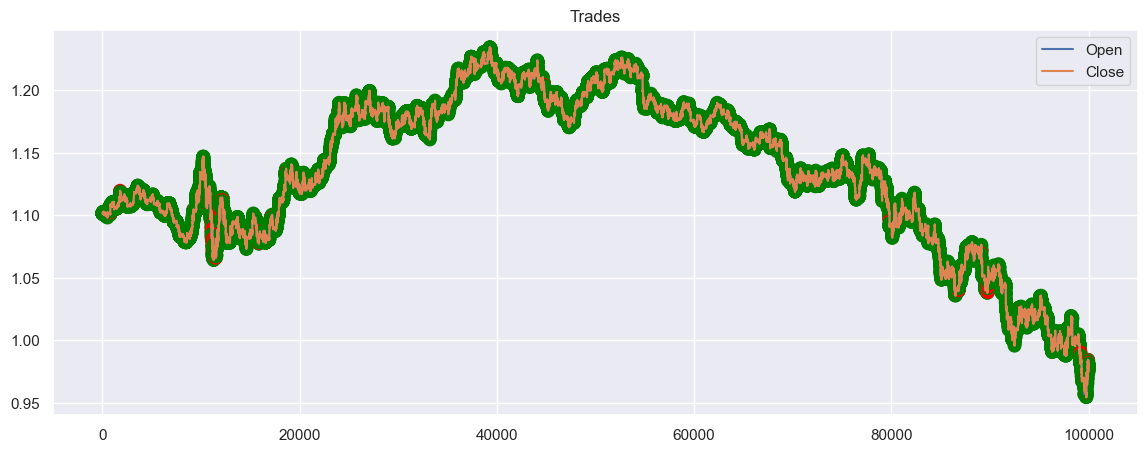

In [55]:
eurusd_env_eval.render()

In [56]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

280

### A2C

In [57]:
sys.argv = [
    'python', 
    '--algo', 'a2c',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/a2c.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/a2c.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('ent_coef', 0.0),
             ('gae_lambda', 1.0),
             ('gamma', 0.99),
             ('learning_rate', 0.0007),
             ('max_grad_norm', 0.5),
             ('n_steps', 5),
             ('normalize', {'norm_reward': False}),
             ('normalize_advantage', False),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('use_rms_prop', True),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v1_1


  2%|▌                          | 100310/5000000 [01:02<23:26:12, 58.07it/s]

Eval num_timesteps=100000, episode_reward=-2.49 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200211/5000000 [02:09<25:05:30, 53.14it/s]

Eval num_timesteps=200000, episode_reward=-2.69 +/- 0.00
Episode length: 99999.00 +/- 0.00


  6%|█▌                         | 300221/5000000 [03:11<27:18:56, 47.79it/s]

Eval num_timesteps=300000, episode_reward=-2.85 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|██▏                        | 400219/5000000 [04:18<27:36:29, 46.28it/s]

Eval num_timesteps=400000, episode_reward=-2.84 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|██▋                        | 500226/5000000 [05:24<21:57:11, 56.94it/s]

Eval num_timesteps=500000, episode_reward=-2.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600121/5000000 [06:47<53:36:58, 22.80it/s]

Eval num_timesteps=600000, episode_reward=-3.05 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700134/5000000 [08:14<36:29:55, 32.72it/s]

Eval num_timesteps=700000, episode_reward=-2.76 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800036/5000000 [09:35<52:30:16, 22.22it/s]

Eval num_timesteps=800000, episode_reward=-3.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 18%|████▊                      | 900108/5000000 [11:11<49:55:41, 22.81it/s]

Eval num_timesteps=900000, episode_reward=-2.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000191/5000000 [12:35<27:51:31, 39.88it/s]

Eval num_timesteps=1000000, episode_reward=-2.24 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 22%|█████▋                    | 1100046/5000000 [13:48<41:46:08, 25.94it/s]

Eval num_timesteps=1100000, episode_reward=-2.03 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 24%|██████▏                   | 1200192/5000000 [14:57<25:43:37, 41.03it/s]

Eval num_timesteps=1200000, episode_reward=-1.96 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 26%|██████▊                   | 1300186/5000000 [16:07<24:59:54, 41.11it/s]

Eval num_timesteps=1300000, episode_reward=-1.57 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 28%|███████▎                  | 1400204/5000000 [17:15<21:03:19, 47.49it/s]

Eval num_timesteps=1400000, episode_reward=-1.40 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 30%|███████▊                  | 1500221/5000000 [18:26<20:05:37, 48.38it/s]

Eval num_timesteps=1500000, episode_reward=-1.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▋                  | 1600000/5000000 [19:34<27:08, 2087.44it/s]

Eval num_timesteps=1600000, episode_reward=-0.80 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 34%|████████▊                 | 1700191/5000000 [21:02<27:27:41, 33.38it/s]

Eval num_timesteps=1700000, episode_reward=-0.96 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800201/5000000 [22:06<17:42:05, 50.21it/s]

Eval num_timesteps=1800000, episode_reward=-0.78 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 38%|█████████▉                | 1900160/5000000 [23:11<18:11:37, 47.33it/s]

Eval num_timesteps=1900000, episode_reward=-0.62 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 40%|██████████▍               | 2000216/5000000 [24:15<16:07:00, 51.70it/s]

Eval num_timesteps=2000000, episode_reward=-0.54 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 42%|██████████▉               | 2100225/5000000 [25:19<13:55:24, 57.85it/s]

Eval num_timesteps=2100000, episode_reward=-0.43 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 44%|███████████▍              | 2200216/5000000 [26:22<13:29:20, 57.66it/s]

Eval num_timesteps=2200000, episode_reward=-0.60 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|███████████▉              | 2300222/5000000 [27:28<13:18:52, 56.32it/s]

Eval num_timesteps=2300000, episode_reward=-0.59 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400216/5000000 [28:35<15:59:04, 45.18it/s]

Eval num_timesteps=2400000, episode_reward=-0.45 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500210/5000000 [29:44<17:18:06, 40.13it/s]

Eval num_timesteps=2500000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 52%|█████████████▌            | 2600219/5000000 [30:50<12:21:36, 53.93it/s]

Eval num_timesteps=2600000, episode_reward=-0.32 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 54%|██████████████            | 2700207/5000000 [31:59<15:10:53, 42.08it/s]

Eval num_timesteps=2700000, episode_reward=-0.41 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|██████████████▌           | 2800266/5000000 [33:03<10:48:22, 56.54it/s]

Eval num_timesteps=2800000, episode_reward=-0.40 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████           | 2900231/5000000 [34:05<10:43:53, 54.35it/s]

Eval num_timesteps=2900000, episode_reward=-0.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|███████████████▌          | 3000229/5000000 [35:08<11:22:42, 48.82it/s]

Eval num_timesteps=3000000, episode_reward=-0.38 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████          | 3100228/5000000 [36:11<10:13:34, 51.60it/s]

Eval num_timesteps=3100000, episode_reward=-0.31 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 64%|█████████████████▎         | 3200221/5000000 [37:12<8:46:33, 56.97it/s]

Eval num_timesteps=3200000, episode_reward=-0.21 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 66%|█████████████████▊         | 3300261/5000000 [38:14<7:44:11, 61.03it/s]

Eval num_timesteps=3300000, episode_reward=-0.11 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 68%|██████████████████▎        | 3400220/5000000 [39:16<7:52:17, 56.45it/s]

Eval num_timesteps=3400000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 70%|██████████████████▉        | 3500227/5000000 [40:17<6:57:25, 59.88it/s]

Eval num_timesteps=3500000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600231/5000000 [41:18<7:09:38, 54.30it/s]

Eval num_timesteps=3600000, episode_reward=-0.16 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700226/5000000 [42:19<6:22:17, 56.67it/s]

Eval num_timesteps=3700000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


 76%|████████████████████▌      | 3800229/5000000 [43:21<6:49:10, 48.87it/s]

Eval num_timesteps=3800000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900229/5000000 [44:22<5:37:53, 54.25it/s]

Eval num_timesteps=3900000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000429/5000000 [45:23<4:29:44, 61.76it/s]

Eval num_timesteps=4000000, episode_reward=-0.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100238/5000000 [46:24<4:05:11, 61.16it/s]

Eval num_timesteps=4100000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200337/5000000 [47:25<3:34:18, 62.19it/s]

Eval num_timesteps=4200000, episode_reward=-0.17 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300229/5000000 [48:27<3:56:19, 49.35it/s]

Eval num_timesteps=4300000, episode_reward=-0.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400231/5000000 [49:28<2:50:27, 58.64it/s]

Eval num_timesteps=4400000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500231/5000000 [50:30<2:49:01, 49.28it/s]

Eval num_timesteps=4500000, episode_reward=-0.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600212/5000000 [51:32<2:17:57, 48.30it/s]

Eval num_timesteps=4600000, episode_reward=-0.15 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700193/5000000 [52:33<1:55:31, 43.25it/s]

Eval num_timesteps=4700000, episode_reward=-0.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|███████████████████████████▊ | 4800301/5000000 [53:35<56:05, 59.33it/s]

Eval num_timesteps=4800000, episode_reward=-0.13 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900221/5000000 [54:37<31:34, 52.67it/s]

Eval num_timesteps=4900000, episode_reward=-0.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


100%|███████████████████████████| 5000000/5000000 [55:45<00:00, 1494.56it/s]

Eval num_timesteps=5000000, episode_reward=-0.13 +/- 0.00
Episode length: 99999.00 +/- 0.00
Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/a2c/ForexFullEURUSD-v1_1


#### Final model

In [58]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v1')

Loading latest experiment, id=1


In [59]:
model = A2C.load(model_path)

##### Train set results

In [61]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [62]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:52<00:00, 4389.04it/s]


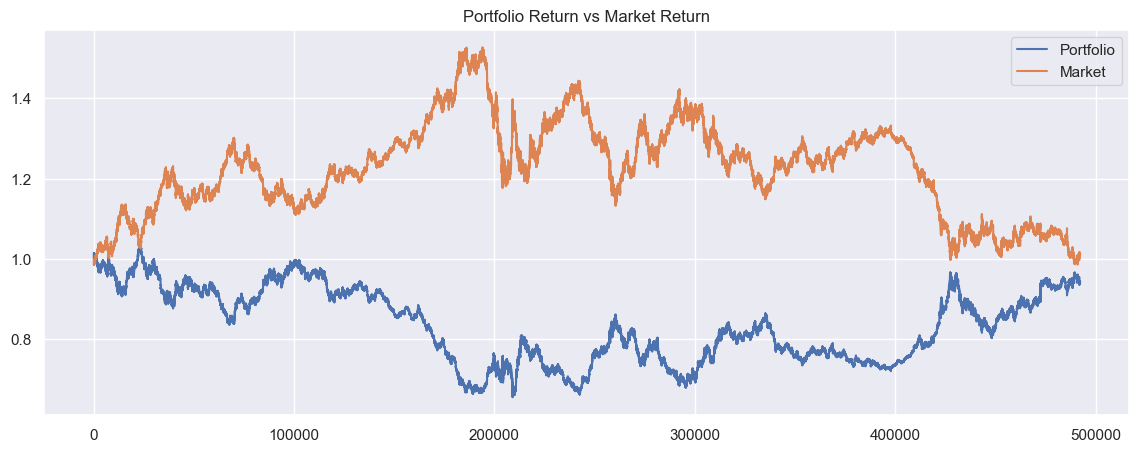

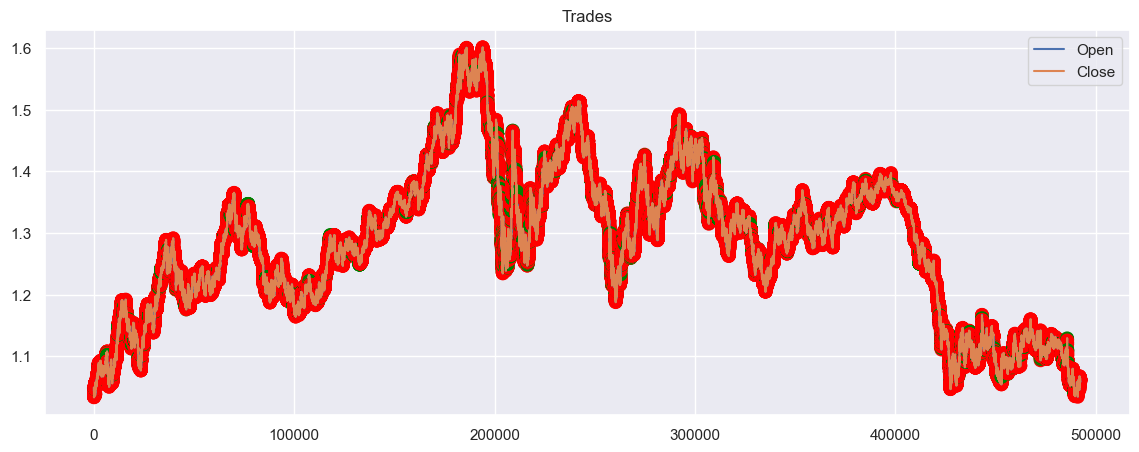

In [63]:
eurusd_env_trn.render()

In [64]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

2635

##### Validation set results

In [65]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [66]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4282.98it/s]


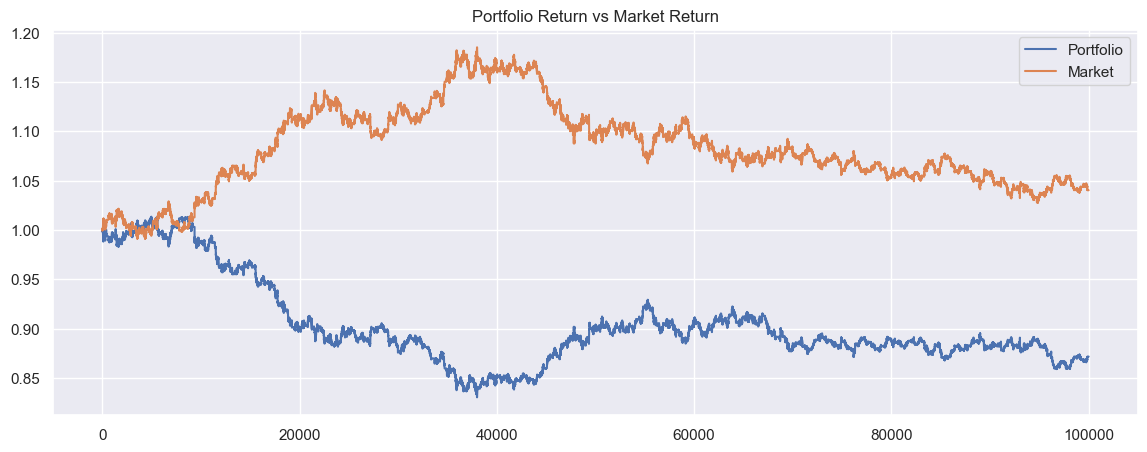

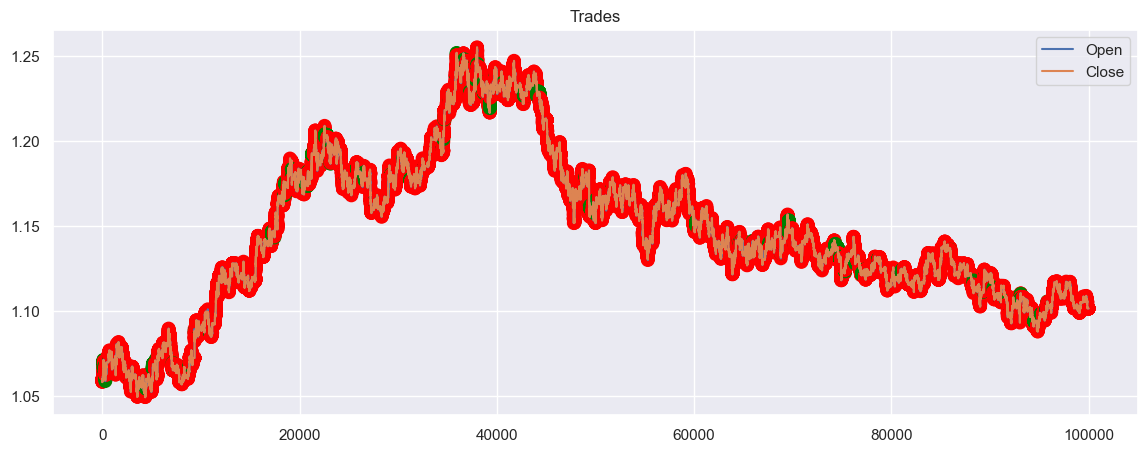

In [67]:
eurusd_env_val.render()

In [68]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

144

##### Evaluation set results

In [69]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [70]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4357.37it/s]


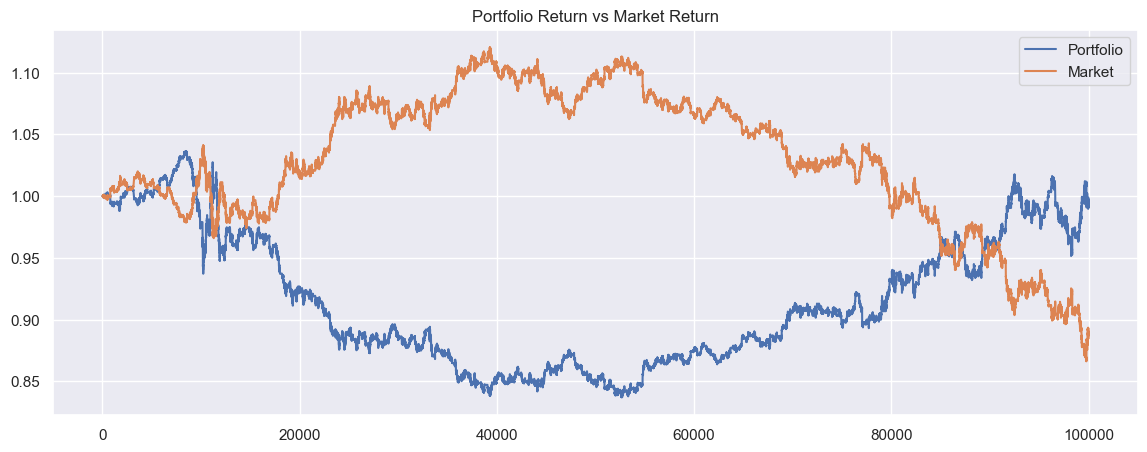

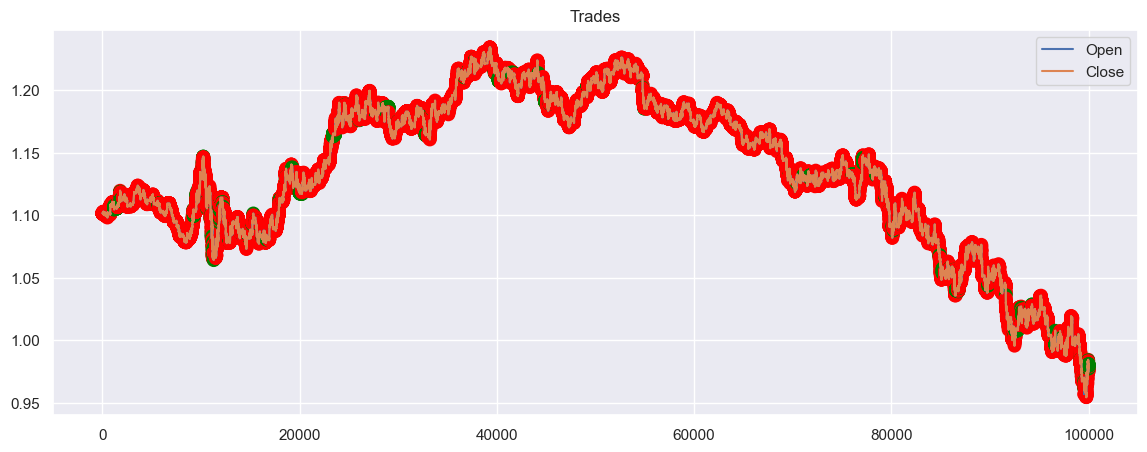

In [71]:
eurusd_env_eval.render()

In [72]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

237

#### Best model

In [73]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'a2c', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=1


In [74]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [75]:
best_model_vecnormalize

'vecnormalize_3700000_steps.pkl'

In [76]:
best_model = A2C.load(best_model_path)

##### Train set results

In [77]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [78]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:53<00:00, 4322.99it/s]


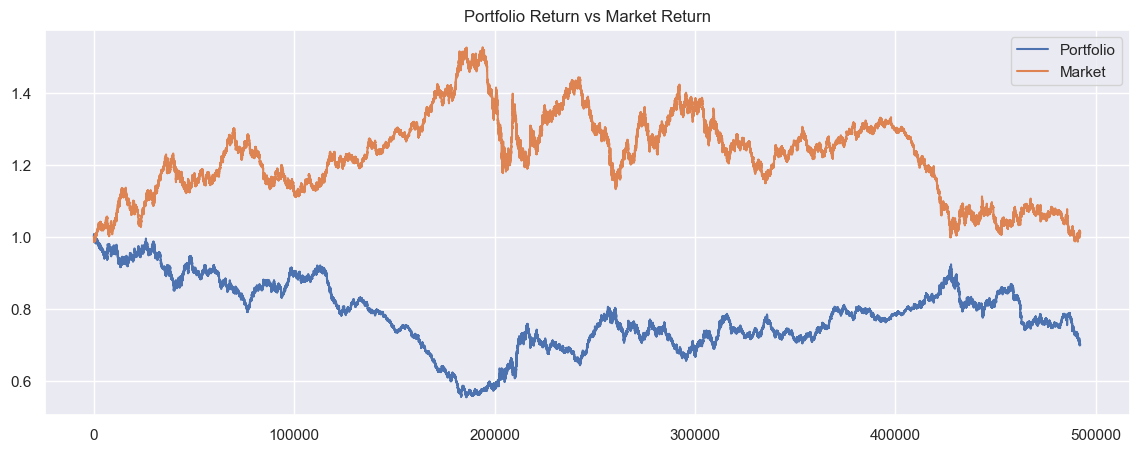

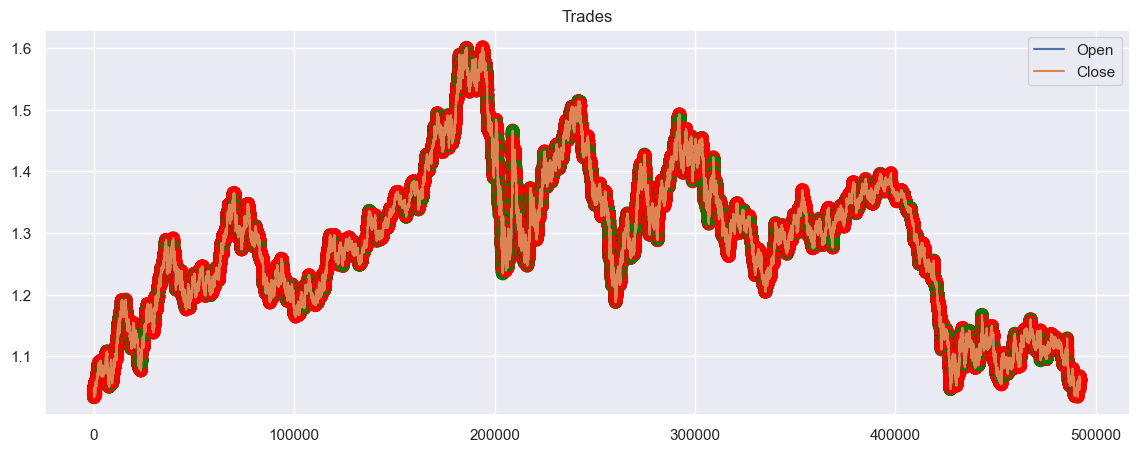

In [80]:
eurusd_env_trn.render()

In [81]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

9830

##### Validation set results

In [82]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [83]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4231.38it/s]


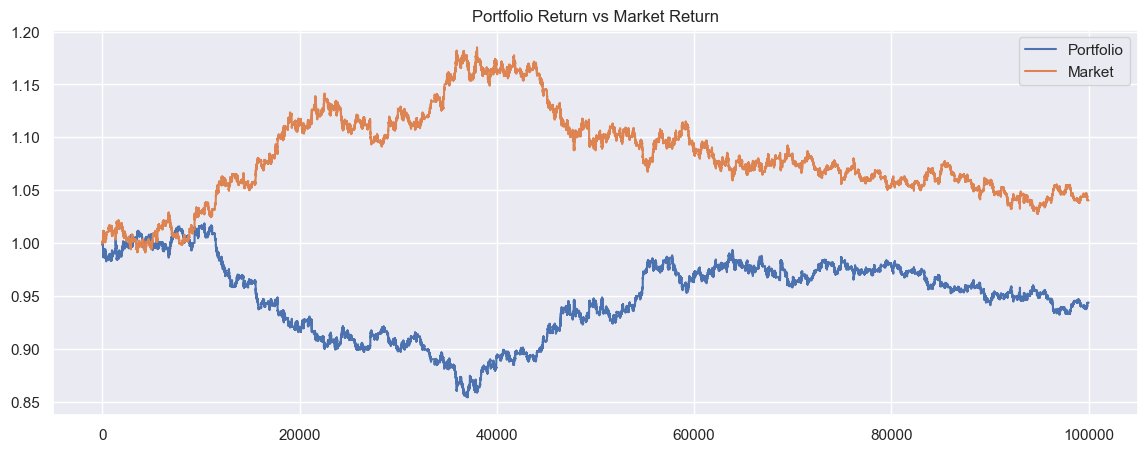

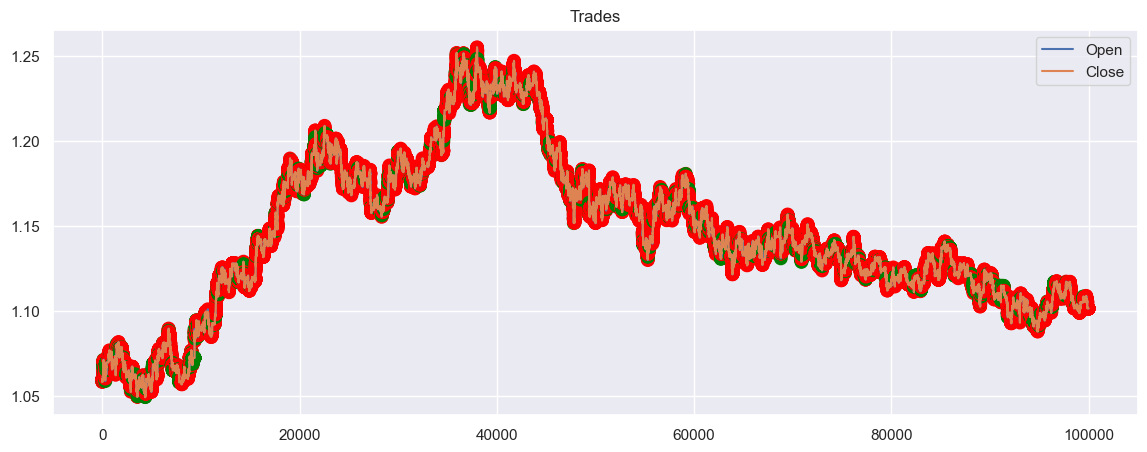

In [85]:
eurusd_env_val.render()

In [84]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

907

##### Evaluation set results

In [86]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [87]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4396.71it/s]


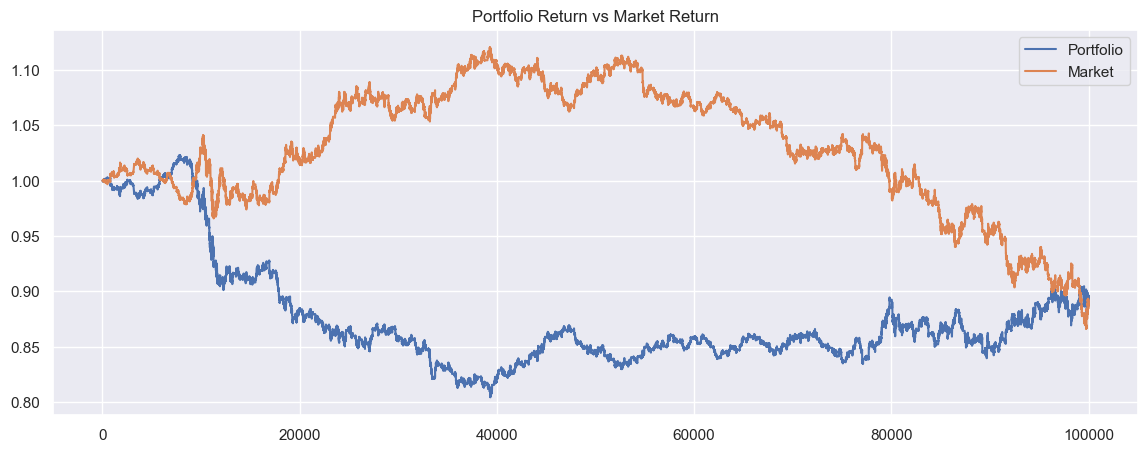

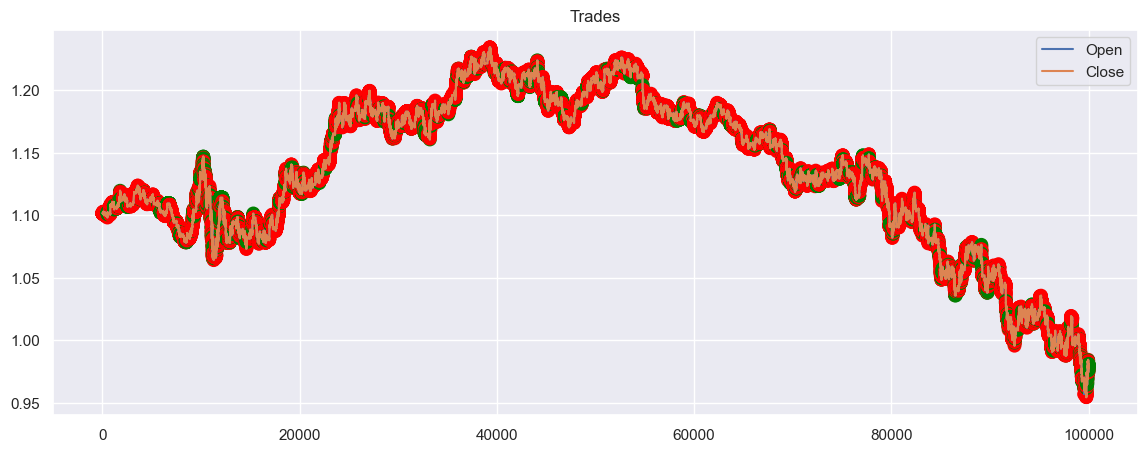

In [88]:
eurusd_env_eval.render() 

In [90]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

1264

### PPO

In [89]:
sys.argv = [
    'python', 
    '--algo', 'ppo',
    '--env', 'ForexFullEURUSD-v1',
    '--tensorboard-log', f'{LOGS_PATH}/training/TensorBoard',
    '--n-timesteps', '5000000',
    '--eval-freq', '100000',
    '--eval-episodes', '1',
    '--log-folder', f'{LOGS_PATH}/training',
    '--seed', '604',
    '--verbose', '0',
    '--hyperparams', 'normalize:dict(norm_reward=False)', 'callback:"rl_trading.utils.TextProgressBarCallback"',
    '--conf-file', f'{HYPERPARAMS_PATH}/default/ppo.yml'
]

train()

========== ForexFullEURUSD-v1 ==========
Seed: 604
Loading hyperparameters from: /Users/astepura/Desktop/I-CUREUS/RL-trading/hyperparams/default/ppo.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 64),
             ('callback', 'rl_trading.utils.TextProgressBarCallback'),
             ('clip_range', 0.2),
             ('ent_coef', 0.0),
             ('gae_lambda', 0.95),
             ('gamma', 0.99),
             ('learning_rate', 0.0003),
             ('max_grad_norm', 0.5),
             ('n_epochs', 10),
             ('n_steps', 2048),
             ('normalize', {'norm_reward': False}),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs',
              'dict( net_arch=[dict(pi=[64, 64], vf=[64, 64])], '
              'activation_fn=nn.Tanh, ortho_init=True )'),
             ('vf_coef', 0.5)])
Log path: /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v1_1


  2%|▌                          | 100047/5000000 [01:00<21:31:33, 63.23it/s]

Eval num_timesteps=100000, episode_reward=-2.18 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  4%|█                          | 200340/5000000 [02:03<19:04:41, 69.88it/s]

Eval num_timesteps=200000, episode_reward=-1.44 +/- 0.00
Episode length: 99999.00 +/- 0.00
New best mean reward!


  6%|█▌                         | 300395/5000000 [03:04<13:31:39, 96.50it/s]

Eval num_timesteps=300000, episode_reward=-2.22 +/- 0.00
Episode length: 99999.00 +/- 0.00


  8%|██▏                        | 400359/5000000 [04:07<15:41:13, 81.45it/s]

Eval num_timesteps=400000, episode_reward=-1.78 +/- 0.00
Episode length: 99999.00 +/- 0.00


 10%|██▋                        | 500383/5000000 [05:11<14:19:55, 87.21it/s]

Eval num_timesteps=500000, episode_reward=-1.73 +/- 0.00
Episode length: 99999.00 +/- 0.00


 12%|███▏                       | 600001/5000000 [06:11<19:46:31, 61.81it/s]

Eval num_timesteps=600000, episode_reward=-1.97 +/- 0.00
Episode length: 99999.00 +/- 0.00


 14%|███▊                       | 700398/5000000 [07:12<14:01:11, 85.19it/s]

Eval num_timesteps=700000, episode_reward=-1.87 +/- 0.00
Episode length: 99999.00 +/- 0.00


 16%|████▎                      | 800401/5000000 [08:13<12:31:05, 93.19it/s]

Eval num_timesteps=800000, episode_reward=-1.84 +/- 0.00
Episode length: 99999.00 +/- 0.00


 18%|████▊                      | 900373/5000000 [09:16<12:35:48, 90.40it/s]

Eval num_timesteps=900000, episode_reward=-1.92 +/- 0.00
Episode length: 99999.00 +/- 0.00


 20%|█████▏                    | 1000347/5000000 [10:21<13:59:57, 79.36it/s]

Eval num_timesteps=1000000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 22%|█████▋                    | 1100370/5000000 [11:29<22:05:32, 49.03it/s]

Eval num_timesteps=1100000, episode_reward=-1.95 +/- 0.00
Episode length: 99999.00 +/- 0.00


 24%|██████▏                   | 1200001/5000000 [12:29<15:39:27, 67.41it/s]

Eval num_timesteps=1200000, episode_reward=-2.00 +/- 0.00
Episode length: 99999.00 +/- 0.00


 26%|██████▊                   | 1300379/5000000 [13:33<13:33:09, 75.83it/s]

Eval num_timesteps=1300000, episode_reward=-2.37 +/- 0.00
Episode length: 99999.00 +/- 0.00


 28%|███████▎                  | 1400652/5000000 [14:32<10:02:37, 99.55it/s]

Eval num_timesteps=1400000, episode_reward=-2.25 +/- 0.00
Episode length: 99999.00 +/- 0.00


 30%|███████▊                  | 1500391/5000000 [15:33<11:55:52, 81.48it/s]

Eval num_timesteps=1500000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 32%|████████▎                 | 1600336/5000000 [16:35<13:17:16, 71.07it/s]

Eval num_timesteps=1600000, episode_reward=-1.79 +/- 0.00
Episode length: 99999.00 +/- 0.00


 34%|████████▊                 | 1700392/5000000 [17:38<13:40:23, 67.03it/s]

Eval num_timesteps=1700000, episode_reward=-1.87 +/- 0.00
Episode length: 99999.00 +/- 0.00


 36%|█████████▎                | 1800070/5000000 [18:42<13:57:07, 63.71it/s]

Eval num_timesteps=1800000, episode_reward=-2.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 38%|█████████▉                | 1900336/5000000 [19:46<12:02:25, 71.51it/s]

Eval num_timesteps=1900000, episode_reward=-1.77 +/- 0.00
Episode length: 99999.00 +/- 0.00


 40%|██████████▍               | 2000286/5000000 [20:51<11:01:17, 75.60it/s]

Eval num_timesteps=2000000, episode_reward=-2.18 +/- 0.00
Episode length: 99999.00 +/- 0.00


 42%|██████████▉               | 2100383/5000000 [21:54<10:16:53, 78.34it/s]

Eval num_timesteps=2100000, episode_reward=-2.54 +/- 0.00
Episode length: 99999.00 +/- 0.00


 44%|███████████▉               | 2200373/5000000 [22:53<9:36:29, 80.94it/s]

Eval num_timesteps=2200000, episode_reward=-2.35 +/- 0.00
Episode length: 99999.00 +/- 0.00


 46%|████████████▍              | 2300346/5000000 [23:53<8:27:12, 88.71it/s]

Eval num_timesteps=2300000, episode_reward=-2.29 +/- 0.00
Episode length: 99999.00 +/- 0.00


 48%|████████████▍             | 2400001/5000000 [24:58<14:36:25, 49.44it/s]

Eval num_timesteps=2400000, episode_reward=-2.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 50%|█████████████             | 2500374/5000000 [26:04<10:10:40, 68.22it/s]

Eval num_timesteps=2500000, episode_reward=-2.04 +/- 0.00
Episode length: 99999.00 +/- 0.00


 52%|██████████████             | 2600383/5000000 [27:11<8:40:02, 76.90it/s]

Eval num_timesteps=2600000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 54%|██████████████▌            | 2700317/5000000 [28:15<7:47:54, 81.91it/s]

Eval num_timesteps=2700000, episode_reward=-2.24 +/- 0.00
Episode length: 99999.00 +/- 0.00


 56%|███████████████            | 2800380/5000000 [29:16<7:05:25, 86.17it/s]

Eval num_timesteps=2800000, episode_reward=-1.81 +/- 0.00
Episode length: 99999.00 +/- 0.00


 58%|███████████████▋           | 2900339/5000000 [30:19<7:46:13, 75.06it/s]

Eval num_timesteps=2900000, episode_reward=-2.14 +/- 0.00
Episode length: 99999.00 +/- 0.00


 60%|███████████████▌          | 3000001/5000000 [31:20<10:00:49, 55.48it/s]

Eval num_timesteps=3000000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 62%|████████████████▋          | 3100534/5000000 [32:20<5:50:44, 90.26it/s]

Eval num_timesteps=3100000, episode_reward=-2.35 +/- 0.00
Episode length: 99999.00 +/- 0.00


 64%|█████████████████▎         | 3200359/5000000 [33:20<5:57:36, 83.87it/s]

Eval num_timesteps=3200000, episode_reward=-2.07 +/- 0.00
Episode length: 99999.00 +/- 0.00


 66%|█████████████████▊         | 3300389/5000000 [34:19<5:22:40, 87.79it/s]

Eval num_timesteps=3300000, episode_reward=-2.09 +/- 0.00
Episode length: 99999.00 +/- 0.00


 68%|██████████████████▎        | 3400394/5000000 [35:19<4:47:09, 92.84it/s]

Eval num_timesteps=3400000, episode_reward=-2.15 +/- 0.00
Episode length: 99999.00 +/- 0.00


 70%|██████████████████▉        | 3500001/5000000 [36:18<8:07:30, 51.28it/s]

Eval num_timesteps=3500000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 72%|███████████████████▍       | 3600001/5000000 [37:19<6:24:35, 60.67it/s]

Eval num_timesteps=3600000, episode_reward=-2.10 +/- 0.00
Episode length: 99999.00 +/- 0.00


 74%|███████████████████▉       | 3700380/5000000 [38:23<5:09:06, 70.07it/s]

Eval num_timesteps=3700000, episode_reward=-2.29 +/- 0.00
Episode length: 99999.00 +/- 0.00


 76%|████████████████████▌      | 3800575/5000000 [39:22<3:27:23, 96.39it/s]

Eval num_timesteps=3800000, episode_reward=-2.06 +/- 0.00
Episode length: 99999.00 +/- 0.00


 78%|█████████████████████      | 3900516/5000000 [40:21<3:08:30, 97.21it/s]

Eval num_timesteps=3900000, episode_reward=-2.12 +/- 0.00
Episode length: 99999.00 +/- 0.00


 80%|█████████████████████▌     | 4000393/5000000 [41:20<3:00:17, 92.41it/s]

Eval num_timesteps=4000000, episode_reward=-2.08 +/- 0.00
Episode length: 99999.00 +/- 0.00


 82%|██████████████████████▏    | 4100001/5000000 [42:21<4:18:35, 58.01it/s]

Eval num_timesteps=4100000, episode_reward=-2.36 +/- 0.00
Episode length: 99999.00 +/- 0.00


 84%|██████████████████████▋    | 4200343/5000000 [43:22<2:20:49, 94.64it/s]

Eval num_timesteps=4200000, episode_reward=-2.47 +/- 0.00
Episode length: 99999.00 +/- 0.00


 86%|███████████████████████▏   | 4300475/5000000 [44:23<2:23:14, 81.40it/s]

Eval num_timesteps=4300000, episode_reward=-2.43 +/- 0.00
Episode length: 99999.00 +/- 0.00


 88%|███████████████████████▊   | 4400388/5000000 [45:26<1:49:57, 90.88it/s]

Eval num_timesteps=4400000, episode_reward=-2.30 +/- 0.00
Episode length: 99999.00 +/- 0.00


 90%|████████████████████████▎  | 4500378/5000000 [46:27<1:28:07, 94.49it/s]

Eval num_timesteps=4500000, episode_reward=-2.23 +/- 0.00
Episode length: 99999.00 +/- 0.00


 92%|████████████████████████▊  | 4600381/5000000 [47:28<1:13:19, 90.84it/s]

Eval num_timesteps=4600000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


 94%|█████████████████████████▍ | 4700001/5000000 [48:27<1:35:55, 52.12it/s]

Eval num_timesteps=4700000, episode_reward=-2.49 +/- 0.00
Episode length: 99999.00 +/- 0.00


 96%|███████████████████████████▊ | 4800401/5000000 [49:26<33:22, 99.68it/s]

Eval num_timesteps=4800000, episode_reward=-2.38 +/- 0.00
Episode length: 99999.00 +/- 0.00


 98%|████████████████████████████▍| 4900390/5000000 [50:25<17:00, 97.60it/s]

Eval num_timesteps=4900000, episode_reward=-2.59 +/- 0.00
Episode length: 99999.00 +/- 0.00


5000392it [51:24, 88.14it/s]                                                

Eval num_timesteps=5000000, episode_reward=-2.27 +/- 0.00
Episode length: 99999.00 +/- 0.00


5001216it [51:25, 1620.97it/s]

Saving to /Users/astepura/Desktop/I-CUREUS/RL-trading/logs/training/ppo/ForexFullEURUSD-v1_1


#### Final model

In [91]:
_, model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v1')

Loading latest experiment, id=1


In [92]:
model = PPO.load(model_path)

##### Train set results

In [93]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [94]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:50<00:00, 4440.22it/s]


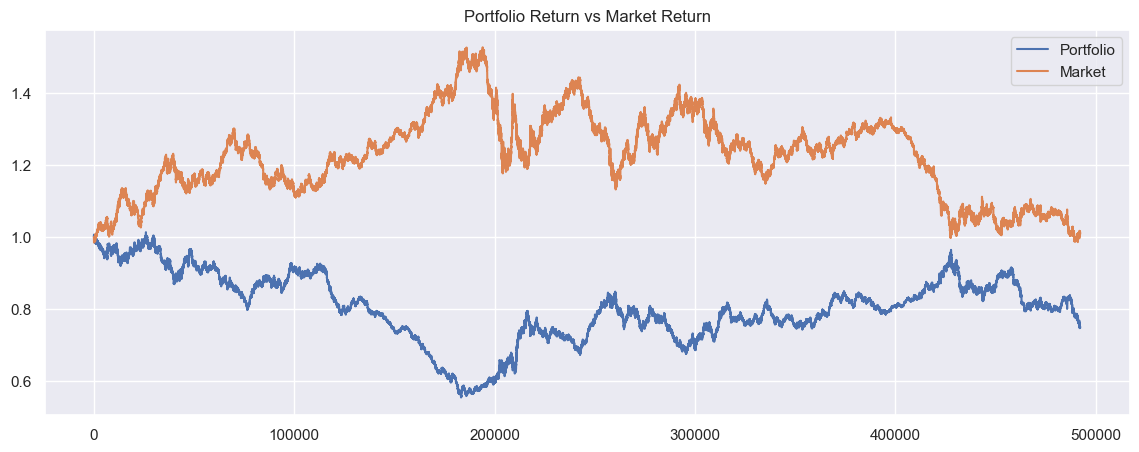

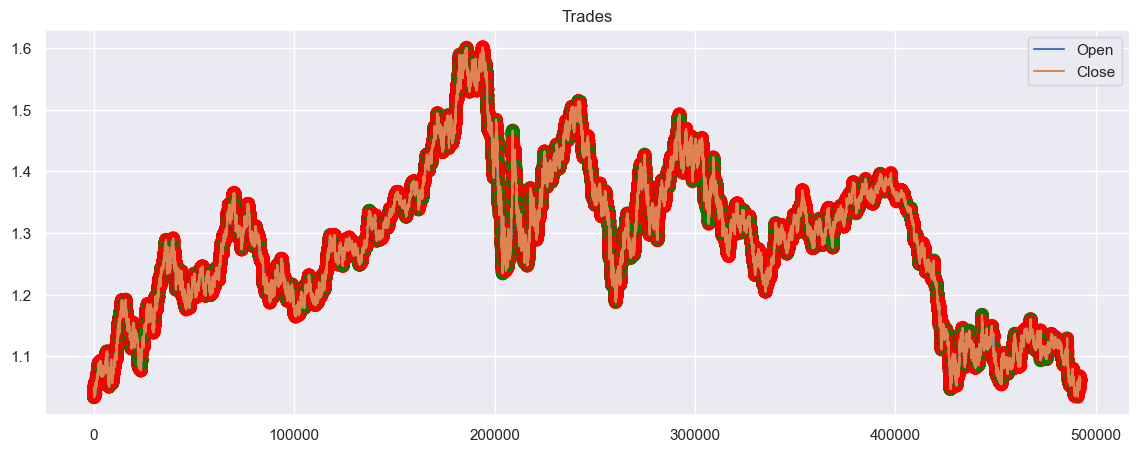

In [95]:
eurusd_env_trn.render()

In [96]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

9813

##### Validation set results

In [97]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [98]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:22<00:00, 4448.81it/s]


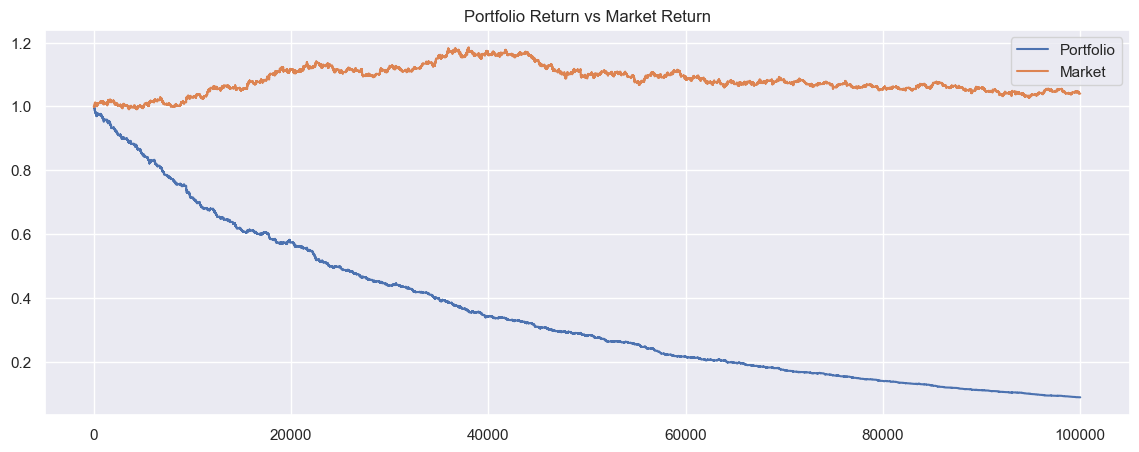

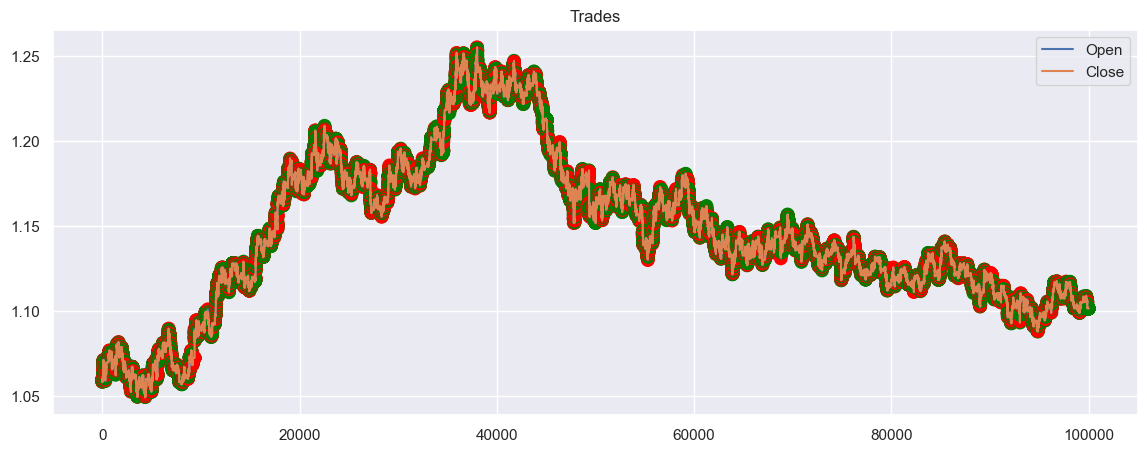

In [101]:
eurusd_env_val.render()

In [102]:
len([fee for fee in eurusd_env_val.get_attr('history')[0]['trading_costs'] if fee != 0])

13462

##### Evaluation set results

In [103]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/vecnormalize.pkl',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [104]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4253.96it/s]


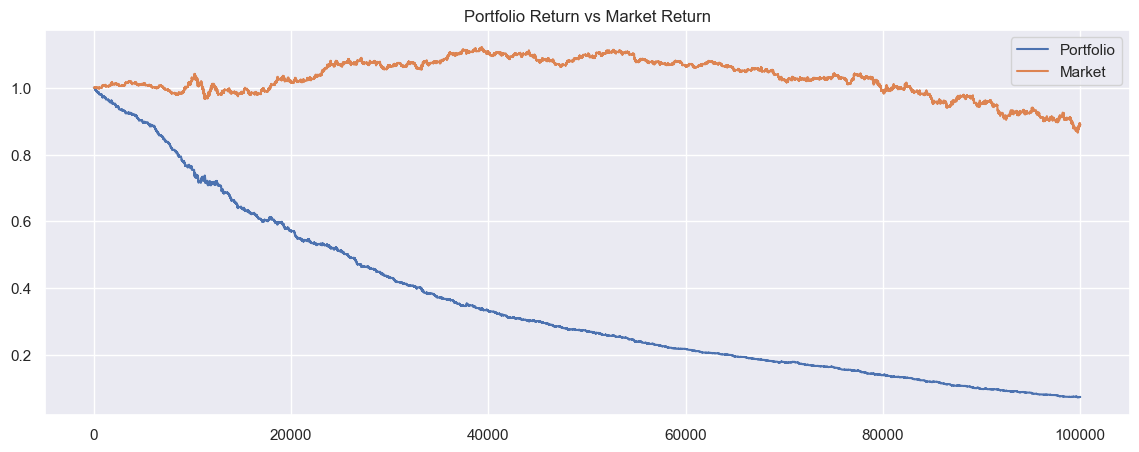

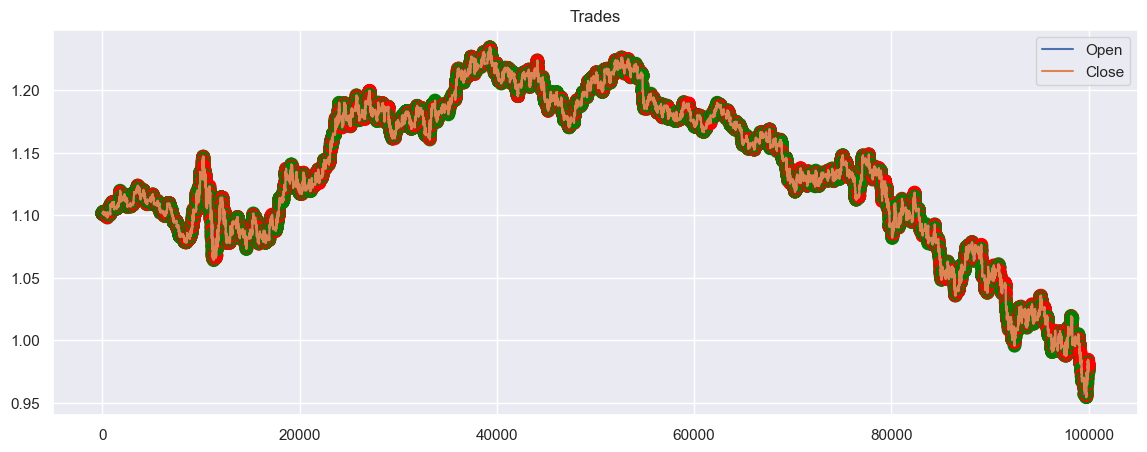

In [107]:
eurusd_env_eval.render()

In [108]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

13776

#### Best model

In [109]:
_, best_model_path, log_path = get_model_path(0, f'{LOGS_PATH}/training', 'ppo', 'ForexFullEURUSD-v1', load_best=True)

Loading latest experiment, id=1


In [110]:
best_model_vecnormalize = sorted(
    [filename for filename in os.listdir(f'{log_path}/ForexFullEURUSD-v1') if 'vecnormalize_' in filename], 
    key=lambda x: int(x.split('_')[1])
)[-1]

In [112]:
best_model_vecnormalize

'vecnormalize_200000_steps.pkl'

In [113]:
best_model = PPO.load(best_model_path)

##### Train set results

In [114]:
eurusd_env_trn = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=False)
    )
)

In [115]:
obs = eurusd_env_trn.reset()
for i in tqdm(range(len(target_prices_trn) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_trn.step(action)

100%|█████████████████████████████| 492325/492325 [01:51<00:00, 4399.71it/s]


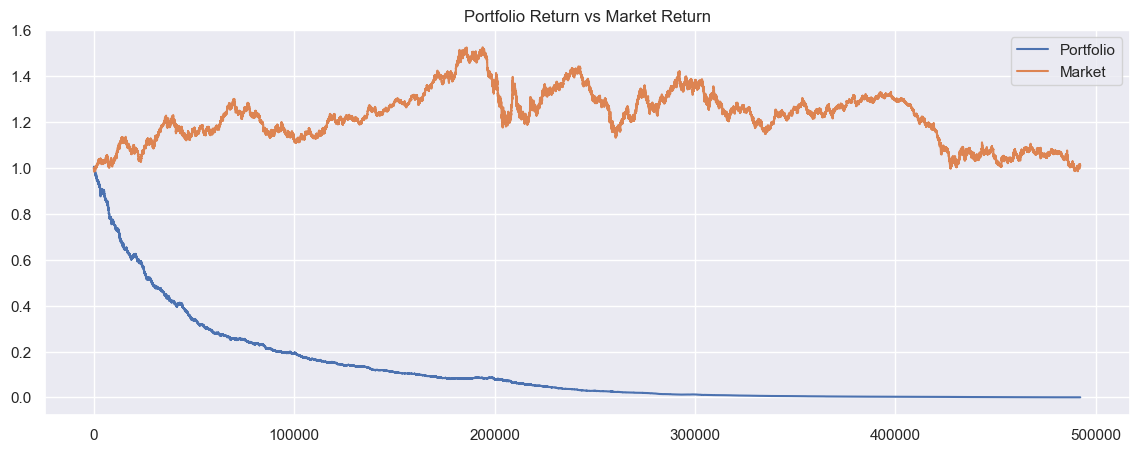

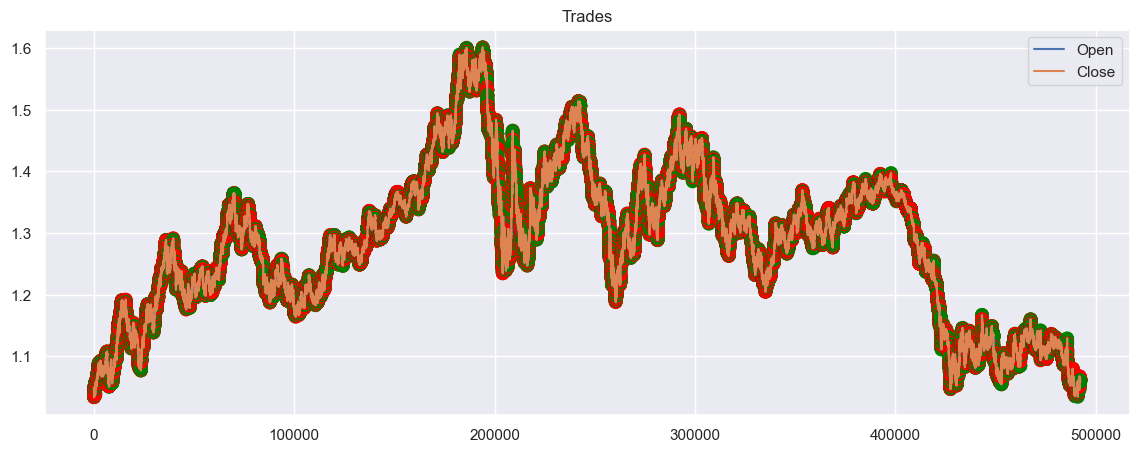

In [116]:
eurusd_env_trn.render()

In [117]:
len([fee for fee in eurusd_env_trn.get_attr('history')[0]['trading_costs'] if fee != 0])

52992

##### Validation set results

In [118]:
eurusd_env_val = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        lambda **kwargs: gym.make('ForexFullEURUSD-v1', **kwargs),
        env_kwargs=dict(eval=True)
    )
)

In [119]:
obs = eurusd_env_val.reset()
for i in tqdm(range(len(target_prices_val) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_val.step(action)

100%|███████████████████████████████| 99998/99998 [00:25<00:00, 3957.69it/s]


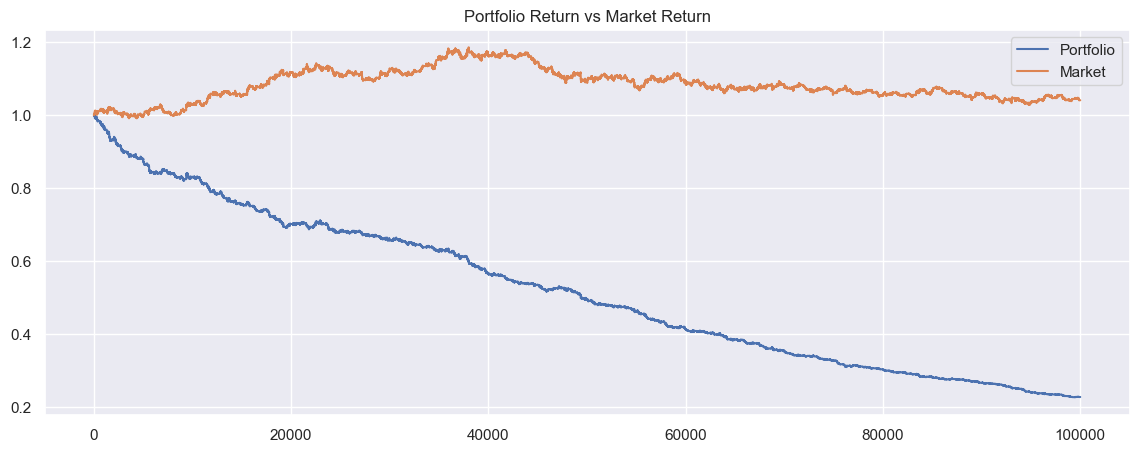

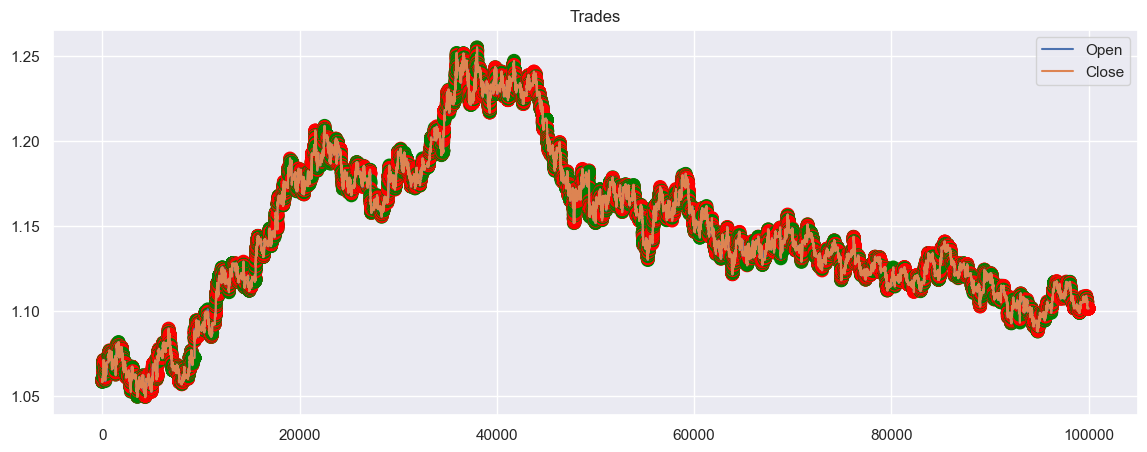

In [120]:
eurusd_env_val.render()

##### Evaluation set results

In [121]:
eurusd_env_eval = VecNormalize.load(
    f'{log_path}/ForexFullEURUSD-v1/{best_model_vecnormalize}',
    make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices_eval,
            features_df=features_eval,
            **deepcopy(BASE_ENV_KWARGS)
        )
    )
)

In [122]:
obs = eurusd_env_eval.reset()
for i in tqdm(range(len(target_prices_eval) - 2)):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_env_eval.step(action)

100%|███████████████████████████████| 99998/99998 [00:23<00:00, 4331.05it/s]


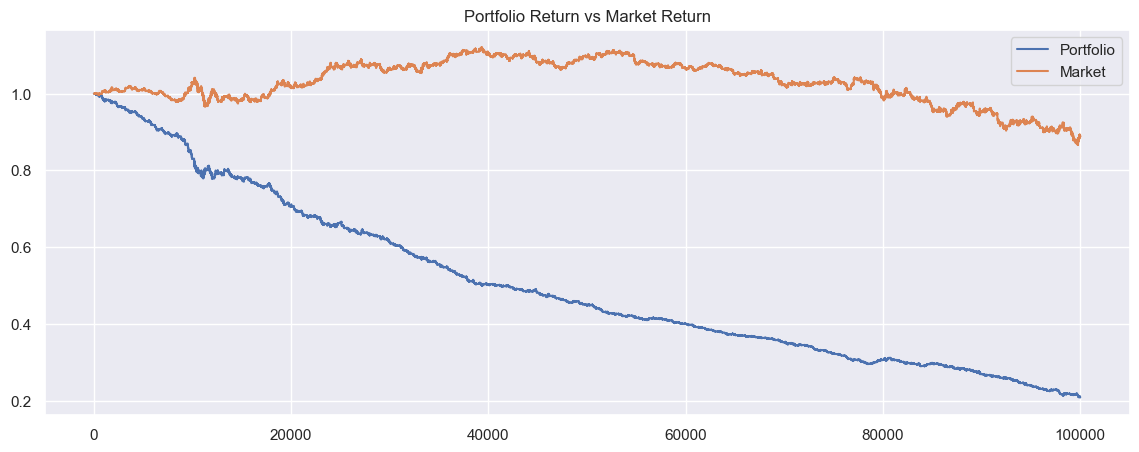

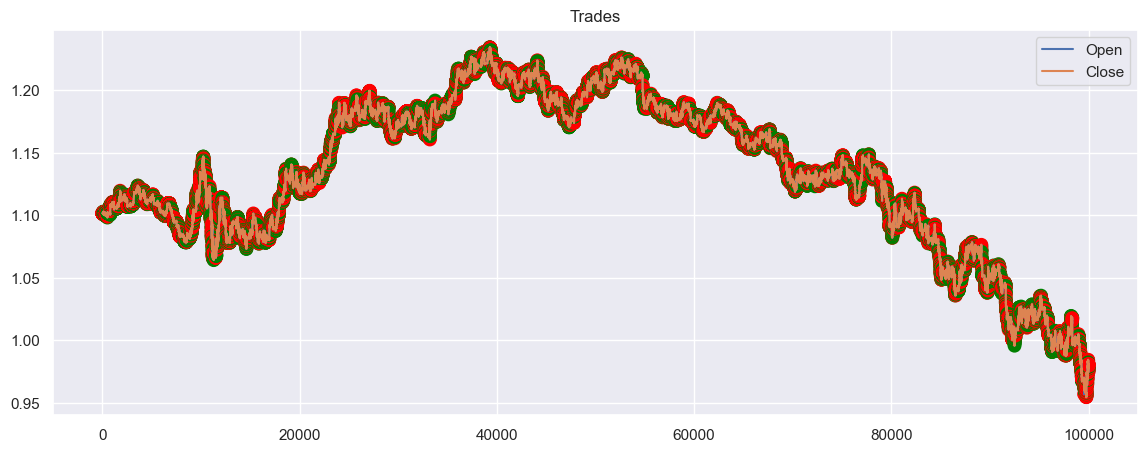

In [123]:
eurusd_env_eval.render()

In [124]:
len([fee for fee in eurusd_env_eval.get_attr('history')[0]['trading_costs'] if fee != 0])

9600